New York's Museum of Modern Art recently posted a [CSV database of their collection on Github](https://github.com/MuseumofModernArt/collection). It's a perfect dataset to demonstrate some of the expressive but relatively user-friendly power of [pandas](http://pandas.pydata.org/). That's what this post is intended to do.

The dataset is also a chance to play with [sexmachine](https://github.com/ferhatelmas/sexmachine/), a python library that attempts to infer a person's gender based on their name, which I'll do in the next post.

This post was written with Jupyter notebook. You can find the original notebook in [my github fork of the MOMA repository](https://github.com/williamsmj/moma-collection).

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('poster')

## Read and clean the data

In [6]:
# Use MOMA's ID as index
# Parse `DateAcquired` column as a datetime
moma = pd.read_csv('Artworks.csv', index_col=12, parse_dates=[10])

# Show the first record to check everything is OK
moma.iloc[0]

﻿Title             Ferdinandsbrücke Project, Vienna, Austria , El...
Artist                                                   Otto Wagner
ArtistBio                                      (Austrian, 1841–1918)
Date                                                            1896
Medium                 Ink and cut-and-pasted painted pages on paper
Dimensions                        19 1/8 x 66 1/2" (48.6 x 168.9 cm)
CreditLine         Fractional and promised gift of Jo Carole and ...
MoMANumber                                                  885.1996
Classification                             A&D Architectural Drawing
Department                                     Architecture & Design
DateAcquired                                     1996-04-09 00:00:00
CuratorApproved                                                    Y
URL                           http://www.moma.org/collection/works/2
Name: 2, dtype: object

In [7]:
# Convert the categorical columns to pandas `category` dtypes. 
# See, e.g. http://blog.dominodatalab.com/pandas-categoricals/ for why this is desirable.
categorical_columns = ['Classification', 'Department', 'CuratorApproved']

for c in categorical_columns:
    moma[c] = moma[c].astype('category')
    print(c, '\n', moma[c].cat.categories)

Classification 
 Index(['(not assigned)', 'A&D Architectural Drawing',
       'A&D Architectural Model', 'A&D Design', 'A&D Graphic Design',
       'A&D Mies van der Rohe Archive', 'A&D Photograph', 'Audio', 'Collage',
       'Drawing', 'Film', 'Film (object)', 'Illustrated Book', 'Installation',
       'Media', 'Multiple', 'Painting', 'Performance', 'Periodical',
       'Photograph', 'Photography Research/Reference', 'Print', 'Sculpture',
       'Textile', 'Video', 'Work on Paper'],
      dtype='object')
Department 
 Index(['Architecture & Design', 'Architecture & Design - Image Archive',
       'Drawings', 'Film', 'Fluxus Collection', 'Media and Performance Art',
       'Painting & Sculpture', 'Photography', 'Prints & Illustrated Books'],
      dtype='object')
CuratorApproved 
 Index(['N', 'Y'], dtype='object')


Most of the plots below depend on the `DateAcquired` field being valid, so I'm going to cheat and dump all the records where it is not.

In [8]:
print(sum(moma['DateAcquired'].isnull()), 'invalid DateAcquired records. Removing.')
moma = moma.dropna(subset=['DateAcquired'])

4428 invalid DateAcquired records. Removing.


## Classifications and departments

We first examine the distribution of items in the collection by classification and department. 

The chain of pandas operations has a lot going on in it, so let's break it down:

 - First we use a pandas `groupby` to group the `moma` DataFrame by `Classification`. `moma.groupby('Classification')` is a `DataFrameGroupBy` object, which can be thought of as a list of pandas DataFrames each of which is made by splitting up the original DataFrame according to the value of `Classification` for each row. 
 - You can iterate over this list, but it's usually more useful to perform an aggregation on it, i.e. to collapse each DataFrames the `DataFrameGroupBy` object into a single row. I just want to know how many items there are in each class, so I use `.count()`.
 - `moma.groupby('Classification')['Classification'].count()` is then a pandas Series, which we can sort and plot as a horizontal bar graph (`kind='barh'`).

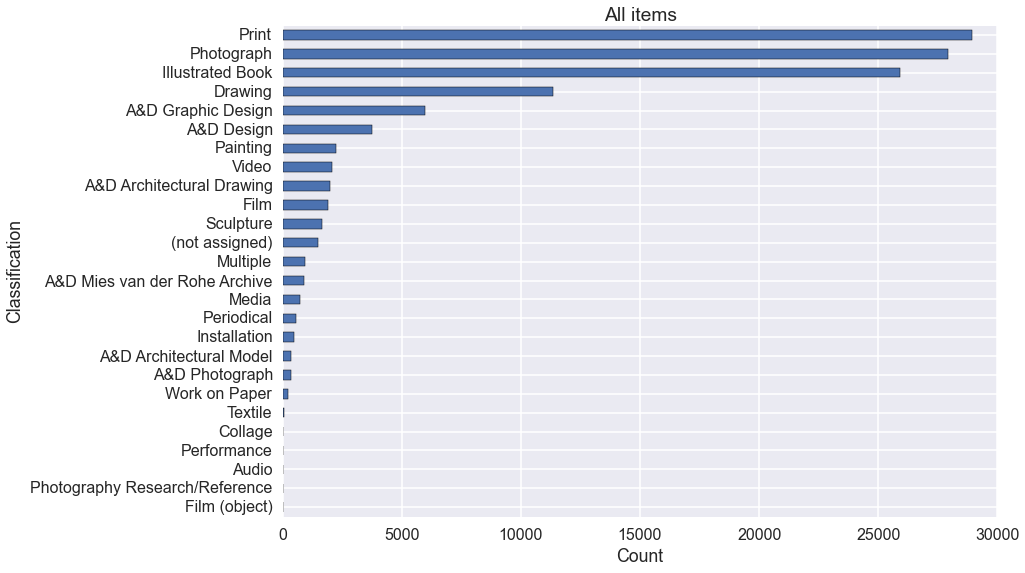

In [27]:
fig, ax = plt.subplots()
ax.set_title('All items')
ax.set_xlabel('Count')

(moma.groupby('Classification')['Classification'].count()
 .sort_values()
 .plot(kind='barh'));

Now we can do the same thing by `Department`.

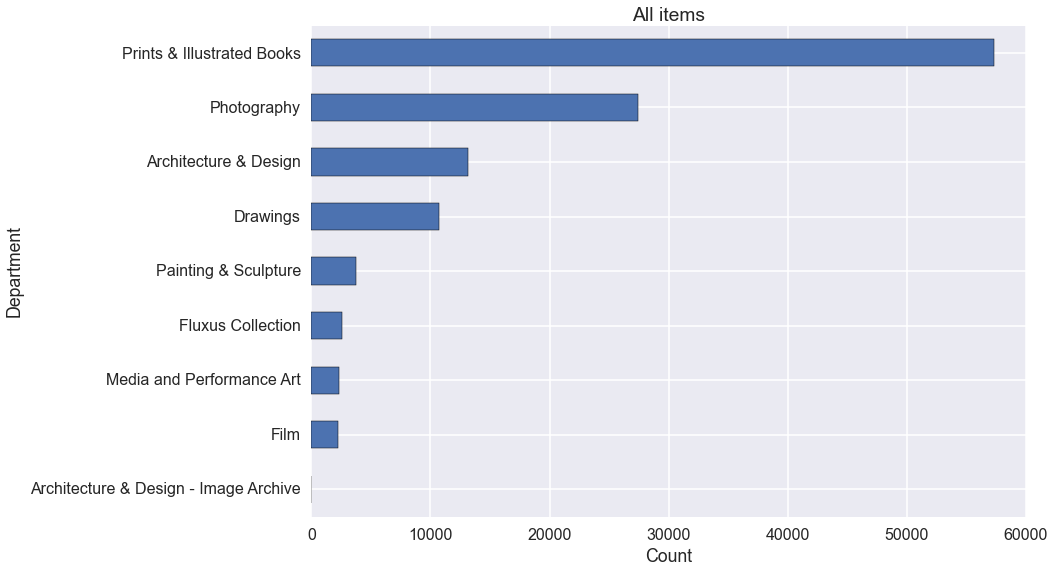

In [10]:
fig, ax = plt.subplots()
ax.set_title('All items')
ax.set_xlabel('Count')

(moma.groupby('Department')['Department'].count()
 .sort_values()
 .plot(kind='barh'));

For obvious reasons, there are many more prints, photographs and books than any other class of work. If you're only interested in paintings, sculptures and installations then records where `Department` is `Paintings & Sculpture` provides a way to select those out.

## Artists

Which artists have the most items in the MOMA collection?

We can do this with the same `groupby()`, `count()` and `sort_values()` operations. The only difference here is that I add a `tail()` after the `sort()`, which gives us a list of the top 20 (`sort_values()` is ascending by default).

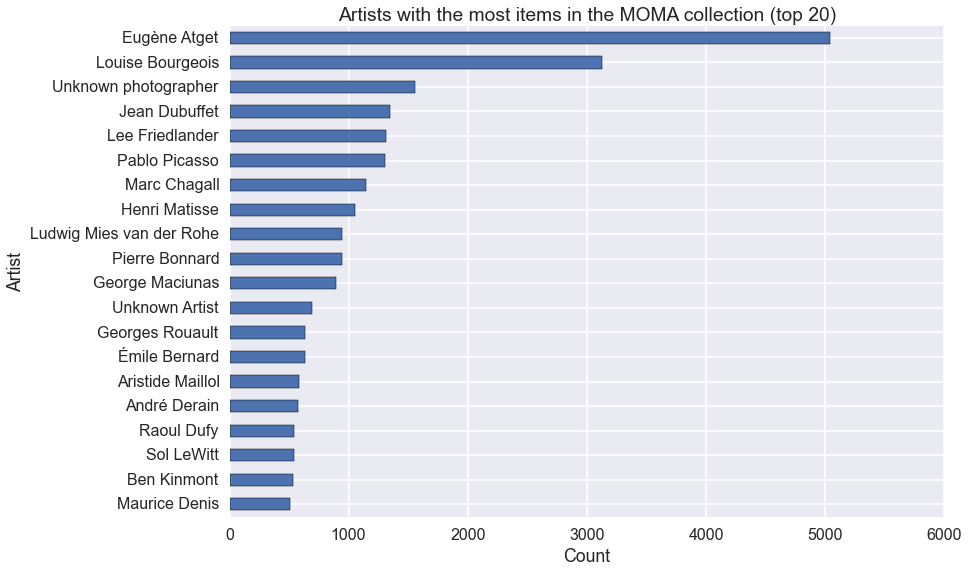

In [11]:
fig, ax = plt.subplots()
ax.set_title('Artists with the most items in the MOMA collection (top 20)')
ax.set_xlabel('Count')

(moma.groupby('Artist')['Artist']
 .count()
 .sort_values()
 .tail(20)
 .plot(kind='barh'));

Lots of photographers! What if we only look at the Painting & Sculpture Department?

To do this, we need to filter the `moma` DataFrame before we operate on it. Inside the square brackets is `moma['Department'] == 'Painting & Sculpture'`. This is itself a Series, but its values are booleans (`True` and `False`. When this object is used to index a DataFrame (or Series), rows where the boolean Series is `False` are filtered out.

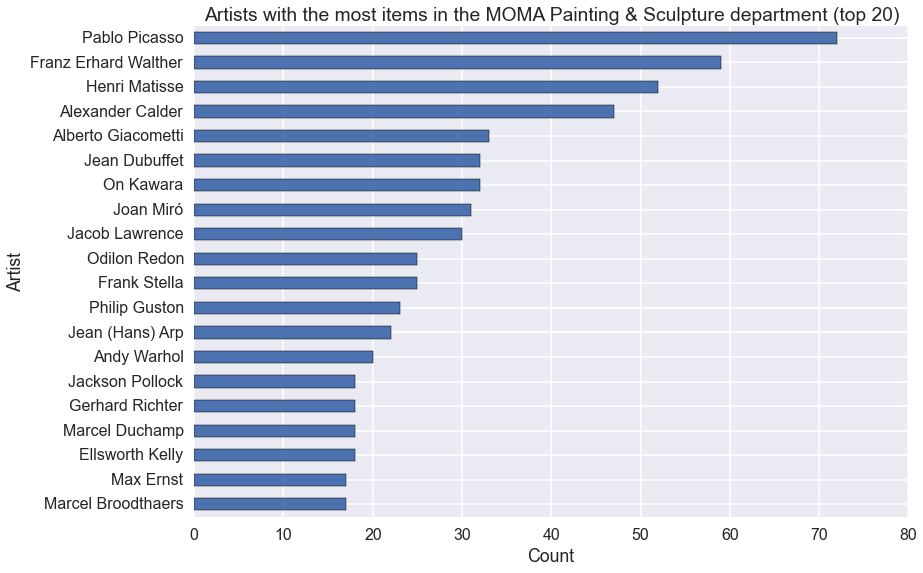

In [28]:
fig, ax = plt.subplots()
ax.set_title('Artists with the most items in the MOMA Painting & Sculpture department (top 20)')
ax.set_xlabel('Count')

(moma[moma['Department'] == 'Painting & Sculpture']
 .groupby('Artist')['Artist']
 .count()
 .sort_values()
 .tail(20)
 .plot(kind='barh'));

Lots of men! (I'll revisit that in a future post.)

## Overall trends with time

Looking at patterns with time is trickier, but easier in pandas than it would otherwise be!

We can use the pandas `Grouper` object to group into years. The constructor for this object takes:

 - a `key` keyword which tells the groupby operation which column contains the datetime we're grouping by, and
 - `freq` keyword, which is usually [a string denoting some frequency](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases). In this case, `'A'` denotes year end. We could have used `'AS'` for year start, or `'Q'` for quarter end, or any of the other offset aliases defined by pandas.
 
Months of the year and days of the week are not intervals of time but rather recurring bins of time, so we can't use the `Grouper()` objects for those. Rather, we apply inline `lambda` function (e.g. `lambda x: x.month`) to the `DateAcquired` field to pick out the month or day of the week from the datetime object in that field. We can then `groupby` that. (And do some tedious work to fix the axes labels.)

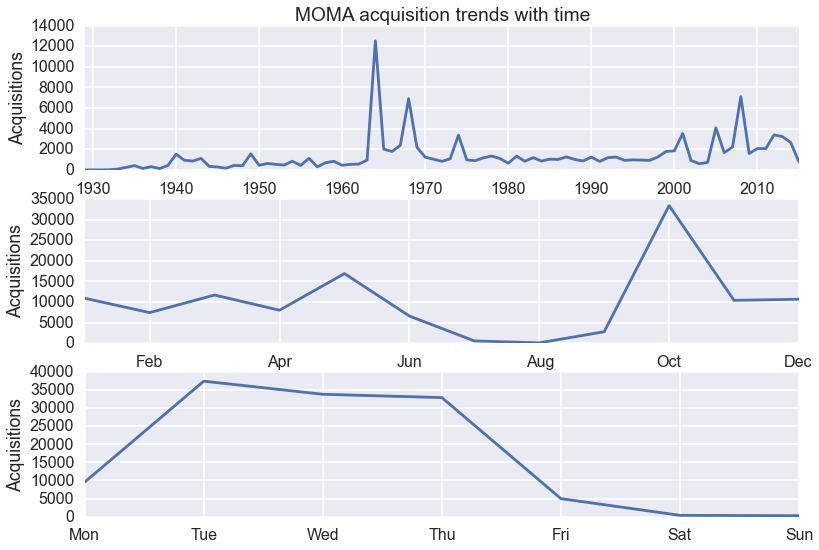

In [24]:
fig, ax = plt.subplots(3, 1);
ylabel = 'Acquisitions'

(moma.groupby(pd.Grouper(freq='A', key='DateAcquired'))['DateAcquired']
 .count()
 .plot(ax=ax[0]))

(moma
 .groupby(moma['DateAcquired'].map(lambda x: x.month))['DateAcquired']
 .count()
 .plot(ax=ax[1]))

(moma.
 groupby(moma['DateAcquired'].map(lambda x: x.weekday()))['DateAcquired']
 .count()
 .plot(ax=ax[2]))

months = {0: '_', 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 
        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 
        10: 'Oct', 11: 'Nov', 12: 'Dec'}
days = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

ax[0].set_title('MOMA acquisition trends with time')
ax[1].set_xticklabels([months[i] for i in ax[1].get_xticks()]);
ax[2].set_xticklabels([days[i] for i in ax[2].get_xticks()]);

for a in ax:
    a.set_xlabel('');
    a.set_ylabel(ylabel);

Lots of acquisitions in 1964, 1968 and 2008. More acquisitions in October than any other month. And Tuesdays are busy!

What happened in 1964? First let's look at the year in detail using pandas datetime slicing, which allows you to use simple strings to refer to datetimes and construct a boolean Series with which to filter the DataFrame.

In [25]:
(moma[(moma['DateAcquired'] > '1964-01-01') &
      (moma['DateAcquired'] < '1964-12-31')]
 .groupby([pd.Grouper(freq='D', key='DateAcquired')])['DateAcquired']
 .count())

DateAcquired
1964-01-04        3
1964-01-07      344
1964-02-11      216
1964-03-10       89
1964-04-06        1
1964-04-14      220
1964-05-12       35
1964-06-15       92
1964-06-26        1
1964-06-29        2
1964-06-30        1
1964-10-06    11259
1964-11-10      233
1964-12-08       24
1964-12-17        1
Name: DateAcquired, dtype: int64

It turns out over 11,000 items were added to the catalog with an acquisition date of 6 October, 1964. Please <a href="mailto:mike@mike.place">let me know</a> if you know the origin of this anomaly.

## Artist trends with time

We looked above at the rate at which MOMA acquires *items*. Now, let's examine the rate at which it adds *artists* to its collection.

We can use `drop_duplicates` to eliminate all but the first record with a given `Artist`, i.e. to remove all items except the first acquisition of an artist's work. We save this in a new DataFrame, and group and plot it as before.

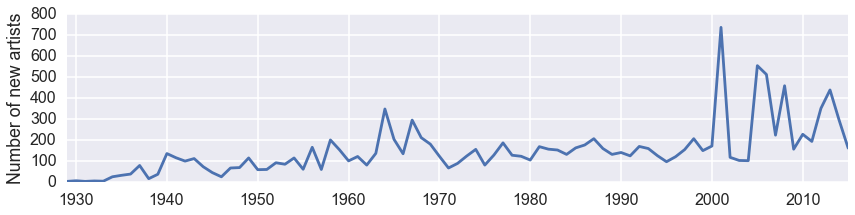

In [29]:
# This is a DataFrame where all items by an artist except their first acquisition are removed
firsts = moma.drop_duplicates('Artist')

fig, ax = plt.subplots(figsize=(14, 3))

(firsts.groupby(pd.Grouper(key='DateAcquired', freq='A'))['DateAcquired']
 .count()
 .plot())

ax.set_xlabel('');
ax.set_ylabel('Number of new artists');

Let's look at trends in the acquisition of the top few artists in the collection of the Painting & Sculpture department, i.e. the people who make paintings, sculptures and installations. First we create a list of who these poeple are.

In [32]:
top = list(moma[moma['Department'] == 'Painting & Sculpture']
            .groupby('Artist')['Artist']
            .count()
            .sort_values()
            .tail(8)
            .index)

Then we use the `isin()` method of a series to construct a boolean Series to filter out people who are not in that list.

/Users/mike/.virtualenvs/ds3/lib/python3.5/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


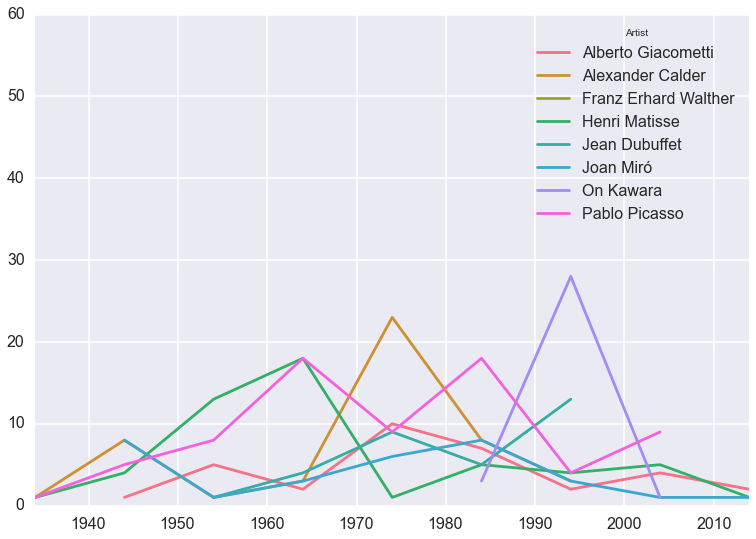

In [33]:
with sns.color_palette(palette='husl', n_colors=8):  # more than 6 colors
    fig, ax = plt.subplots()

    (moma[moma['Artist'].isin(top)
          & (moma['Department'] == 'Painting & Sculpture')]
     .groupby([pd.Grouper(freq='10A', key='DateAcquired'), 'Artist'])['DateAcquired']
     .count()
     .unstack()
     .plot(ax=ax))
    
    ax.set_xlabel('')

This plot is a bit of a mess, since acquisitions by such famous artists are inevitably infrequent and bursty. But clearly there were lots of Calder acquisitions in the 70s and Kawara acquisitions in the 90s.

This is the end of the first post on the MOMA collection dataset. In the second post, I'll look at how the rate at which MOMA acquires work by women has varied over time.